# Deep Learning - Project 2B - Part 1
# Abdul Wahab Akram - 18L-1845

## Major Imports

In [4]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras import applications
from keras import backend as K
from keras.optimizers import SGD
from keras import regularizers
from keras.layers.normalization import BatchNormalization
from keras import optimizers
import os
from os import listdir
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
import numpy as np

## Data Generator Object

In [3]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

## Data Augmentation Function

In [ ]:
def augmentImages(path,sz):
    allfiles=os.listdir(path)
    imlist=[filename for filename in allfiles if  filename[-4:] in [".jpg",".JPG"]]

    for im in imlist:
        imarr=np.array(Image.open(path+im),dtype=np.float)
        imarr = imarr.reshape((1,)+imarr.shape) 
       
        i = 0
        for batch in datagen.flow(imarr, batch_size=1,
                          save_to_dir= path, save_prefix='', save_format='jpg'):
            i += 1
            if i > sz:
                break 

## Augment Data of classes with different size to resolve issue of imbalance classes

In [0]:
augmentsImages('DermCNNdata/1/',18)
augmentsImages('DermCNNdata/2/',18)
augmentsImages('DermCNN/3/',25)
augmentsImages('DermCNN/4/',25)
augmentsImages('DermCNN/5/',28)
augmentsImages('DermCNN/7/',28)

## Variables Initialization

In [5]:
train_data = []
train_labels = []
test_data = []
test_labels = []
im_width = 256
im_height = 256
num_classes = 7

## Preprocessing Function

In [6]:
def preProcessTrainData(path):
    progress = 0
    image_files = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path,f))]
    
    for file_name in image_files:
        image_file = str(path + file_name)
        
        img = cv2.imread(image_file,cv2.IMREAD_GRAYSCALE)
        new_img = cv2.resize(img,(im_width,im_height))
        train_data.append(new_img)
        progress = progress+1
        
        train_labels.append(int(path[-2])-1)
        
        if progress%1000==0:
            print('Progress '+str(progress)+' Image done of Disease type:'  + path[-2])


## Preprocess Data

In [7]:
for i in range(7):
    preProcessTrainData(os.getcwd()+'/DermCNN/'+str(i+1)+'/')

Progress 1000 Image done of Disease type:1
Progress 1000 Image done of Disease type:2
Progress 1000 Image done of Disease type:3
Progress 1000 Image done of Disease type:4
Progress 1000 Image done of Disease type:5
Progress 1000 Image done of Disease type:6
Progress 1000 Image done of Disease type:7


## Converting Training Data List to Numpy array

In [8]:
train_data = np.array(train_data)
print(train_data.shape)

(11746, 256, 256)


## Converting Training Labels to Numpy array

In [9]:
train_labels = np.array(train_labels)
train_labels.shape

(11746,)

## Reshaping data and converting data between 0 and 1

In [ ]:
train_data = train_data.reshape((train_data.shape)[0],(train_data.shape)[1],(train_data.shape)[2],1)
train_data.astype('float32')
train_data = train_data/255.0

In [0]:
train_labels.astype('uint8')
#test_labels.astype('uint8')
train_labels = keras.utils.to_categorical(train_labels, num_classes)
#test_labels = keras.utils.to_categorical(test_labels, num_classes)

## Function to shuffle data

In [0]:
def shuffle(a, b):
    rng_state = np.random.get_state()
    np.random.shuffle(a)
    np.random.set_state(rng_state)
    np.random.shuffle(b)



## Shuffling data and labels in unison

In [0]:
for i in range(10):
    shuffle(train_data,train_labels)

## Model
### 5 convolution layers with large number of filters are used along with 2 dense layers with dropout of 0.5 and 0.4.

In [0]:

model = Sequential()
model.add(Conv2D(kernel_size=(3,3),filters=32,input_shape=(256, 256,
1),activation="relu",padding="valid"))

model.add(Conv2D(kernel_size=(3,3),filters=32,activation="relu",padding="same"))


model.add(Conv2D(kernel_size=(3,3),filters=32)) #previous 32
model.add(Conv2D(kernel_size=(3,3),filters=64,activation="relu",padding="same"))
model.add(Dropout(0.4)) #previous 0.3
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(kernel_size=(3,3),filters=128))

model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(kernel_size=(5,5),filters=128,activation="relu",padding="same"))
model.add(Dropout(0.4)) #previous 0.3

model.add(MaxPooling2D(pool_size=(5,5))) # previous 3


model.add(Flatten())
model.add(Dense(200,activation="relu",kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dropout(0.5)) #previous 0.3

model.add(Dense(100,activation="relu",kernel_regularizer=keras.regularizers.l2(0.01)))
model.add(Dropout(0.4))
model.add(Dense(num_classes,activation="softmax"))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])
model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 254, 254, 32)      320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 254, 254, 32)      9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 252, 252, 32)      9248      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 252, 252, 64)      18496     
_________________________________________________________________
dropout_1 (Dropout)          (None, 252, 252, 64)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 126, 126, 64)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 124, 124, 128)     73856     
__________

## Fit Model

In [0]:
history = model.fit(train_data, train_labels,
          batch_size=30,
                    
          epochs=50,
           verbose=1, shuffle = True,validation_split=0.12)

Train on 10336 samples, validate on 1410 samples
Epoch 1/50
10336/10336 [==============================] - 230s 22ms/step - loss: 2.4246 - acc: 0.2538 - val_loss: 1.8900 - val_acc: 0.2766
Epoch 2/50
10336/10336 [==============================] - 219s 21ms/step - loss: 1.7470 - acc: 0.3758 - val_loss: 1.8130 - val_acc: 0.3220
Epoch 3/50
10336/10336 [==============================] - 219s 21ms/step - loss: 1.6613 - acc: 0.4239 - val_loss: 1.7729 - val_acc: 0.3468
Epoch 4/50
10336/10336 [==============================] - 219s 21ms/step - loss: 1.5892 - acc: 0.4545 - val_loss: 1.7745 - val_acc: 0.3546
Epoch 5/50
10336/10336 [==============================] - 219s 21ms/step - loss: 1.5170 - acc: 0.5046 - val_loss: 1.6851 - val_acc: 0.4085
Epoch 6/50
10336/10336 [==============================] - 219s 21ms/step - loss: 1.4269 - acc: 0.5580 - val_loss: 1.6019 - val_acc: 0.4681
Epoch 7/50
10336/10336 [==============================] - 219s 21ms/step - loss: 1.3693 - acc: 0.5845 - val_loss: 1.6

## Error vs Epochs Plot

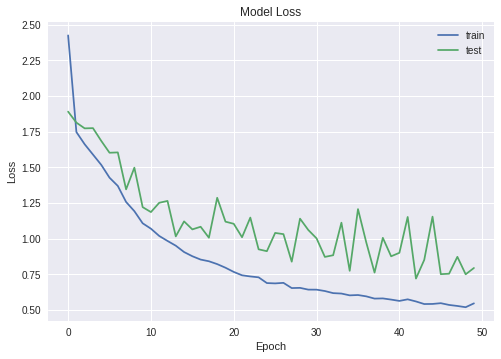

In [0]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

## Accuracy vs Epochs Plot -  Accuracy Achieved (82%)
### As we can see that there are alot of ocillations in test data's accuracy. The model has touched the accuracy of 84% but got 82% accuracy at last epoch because of oscillations. I am expecting more accuracy with this model but could not run it on more epoch because of computation time.

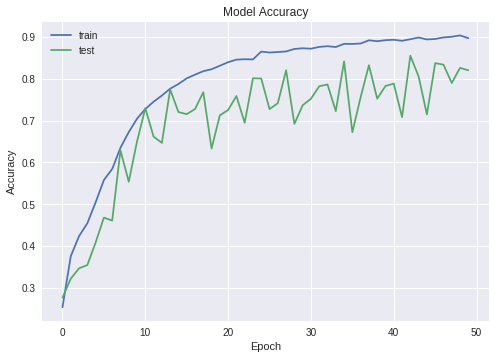

In [0]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()